In [3]:
%load_ext autoreload
%autoreload 2

import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from bs4 import BeautifulSoup as bsoup
from thefuzz import fuzz

from typing import Any, List, Dict, Tuple, Optional

import constants, index_tools, data_tools

from utilities import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
DEV_MODE = True

UK_BIOBANK_DATA_CSV_PATH = constants.UK_BIOBANK_DEV_DATA_CSV if DEV_MODE else constants.UK_BIOBANK_DATA_CSV

# Data Index

In [14]:
biobank_index = index_tools.load_index()

In [15]:
biobank_index = index_tools.add_udi_names_to_index(biobank_index)
udi_map = index_tools.UDIMap(biobank_index)

In [16]:
index_tools.relevant_feature_search(biobank_index, "HTN").head(3)

,column,udi,count,type,description,data_code,data_n_members,data_type,data_structure,name
760,760,2966-0.0,134649,Integer,Age high blood pressure diagnosed,100291,2,integer-valued,simple_list,HTN_dx_age
761,761,2966-1.0,5856,Integer,Age high blood pressure diagnosed,100291,2,integer-valued,simple_list,HTN_dx_age_1.0
762,762,2966-2.0,7559,Integer,Age high blood pressure diagnosed,100291,2,integer-valued,simple_list,HTN_dx_age_2.0


# Load BioBank Data

In [21]:
biobank_data = data_tools.load_biobank_data(UK_BIOBANK_DATA_CSV_PATH, udi_map)
biobank_index = index_tools.add_biobank_info_to_index(biobank_index, biobank_data)
display(biobank_data.head())

UK BioBank Data Loaded.
Size: 9999 rows x 3973 columns


,eid,spirometry_method,spirometry_method_1.0,spirometry_method_2.0,sex,birth_year,blood_sample_attempted,blood_sample_attempted_1.0,blood_sample_attempted_2.0,bp_device,...,important_unlabeled_32,important_unlabeled_33,patient_classification_on_admission,patient_classification_on_admission_0.1,patient_classification_on_admission_0.2,patient_classification_on_admission_0.3,patient_classification_on_admission_0.4,patient_classification_on_admission_0.5,patient_classification_on_admission_0.6,important_unlabeled_34
0,1000015,0.0,NaN,NaN,1,1963,1.0,NaN,NaN,157.0,...,2.0,3.0,2000.0,1000.0,NaN,NaN,NaN,NaN,NaN,5.0
1,1000027,0.0,NaN,NaN,0,1956,1.0,NaN,NaN,3157.0,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
2,1000039,NaN,NaN,NaN,0,1948,1.0,NaN,NaN,1048.0,...,13.0,15.0,2000.0,1000.0,NaN,NaN,NaN,NaN,NaN,19.0
3,1000040,0.0,NaN,NaN,1,1947,1.0,NaN,NaN,1044.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0
4,1000053,0.0,NaN,0.0,0,1962,1.0,NaN,1.0,162.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
biobank_data = data_tools.clean_biobank_data(biobank_data)

In [46]:
UK_BIOBANK_FEATURE_VALUE_REMAPPING = {
    "sex": ["female", "male"]
}

In [47]:
feature_data.query("n_unique < 5")

,feature,feature_samples,n_unique
2,spirometry_method_1.0,"[0.0, 0.0, 0.0]",3
3,spirometry_method_2.0,"[nan, nan, 0.0]",3
4,sex,"[0, 1]",2
6,blood_sample_attempted,"[1.0, 1.0, 0.0]",3
7,blood_sample_attempted_1.0,"[nan, nan, nan]",3
...,...,...,...
2414,hospital_episode_type_0.1,"[2.0, 1.0, 4.0, 1.0]",4
2415,hospital_episode_type_0.2,"[nan, nan]",2
2422,patient_classification_on_admission_0.3,"[1000.0, 2000.0, 2000.0, 1000.0]",4
2423,patient_classification_on_admission_0.4,"[nan, 1000.0, 1001.0]",3


In [25]:
from tqdm.notebook import tqdm
from tqdm import tqdm

In [26]:
feature_data = {"feature": [], "feature_samples": [], "n_unique": []}

for column in tqdm(biobank_data.columns, desc="Analyzing features", unit=" feature"):
    unique_features = biobank_data[column].unique()
    feature_data["feature_samples"].append(np.random.choice(unique_features, min(5, len(unique_features))))
    feature_data["feature"].append(column)
    feature_data["n_unique"].append(len(unique_features))
    
feature_data = pd.DataFrame(feature_data)

Analyzing features: 100%|██████████| 2426/2426 [00:00<00:00, 8303.53 feature/s]


In [27]:
biobank_index.loc[biobank_index["data_type"].isna()]

,column,udi,count,type,description,data_code,data_n_members,data_type,data_structure,name,counts,frequency
0,0,eid,502543,Sequence,Encoded anonymised participant ID,None,None,None,None,eid,9999,1.000000
5,5,34-0.0,502543,Integer,Year of birth,None,None,None,None,birth_year,9999,1.000000
9,9,36-0.0,497907,Text,Blood pressure device ID,None,None,None,None,bp_device,9907,0.990799
10,10,36-1.0,20336,Text,Blood pressure device ID,None,None,None,None,bp_device_1.0,412,0.041204
11,11,36-2.0,27223,Text,Blood pressure device ID,None,None,None,None,bp_device_2.0,534,0.053405
...,...,...,...,...,...,...,...,...,...,...,...,...
3052,3052,41148-0.0,377693,Integer,"Episodes containing ""Date of operation"" data",None,None,None,None,important_unlabeled_27,7522,0.752275
3962,3962,41235-0.0,330471,Integer,Spells in hospital,None,None,None,None,hospital_spells,6525,0.652565
3963,3963,41240-0.0,277019,Integer,"Episodes containing ""Patient classification on...",None,None,None,None,important_unlabeled_32,5456,0.545655
3964,3964,41241-0.0,305421,Integer,"Episodes containing ""Intended management of pa...",None,None,None,None,important_unlabeled_33,6028,0.602860


In [28]:
biobank_index.groupby(by="data_type").count()

,column,udi,count,type,description,data_code,data_n_members,data_structure,name,counts,frequency
data_type,,,,,,,,,,,
integer-valued,2136,2136,2136,2136,2136,2136,2136,2136,2136,2136,2136
real-valued,426,426,426,426,426,426,426,426,426,426,426
string-valued,957,957,957,957,957,957,957,957,957,957,957


<ipython-input-29-79979f850afe>:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([f"{10 ** float(tick._text):,.0f}" for tick in ax.get_xticklabels()]);


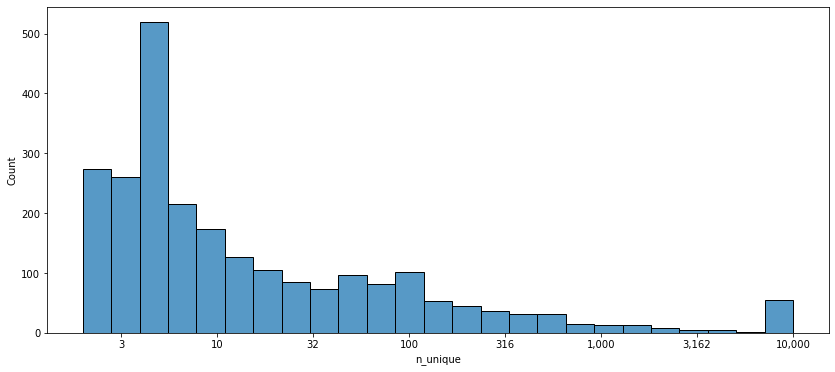

In [29]:
fig, ax = plt.subplots(figsize=(14, 6))
sns.histplot(np.log10(feature_data["n_unique"]), ax=ax)
fig.canvas.draw()
ax.set_xticklabels([f"{10 ** float(tick._text):,.0f}" for tick in ax.get_xticklabels()]);

# Feature Index EDA

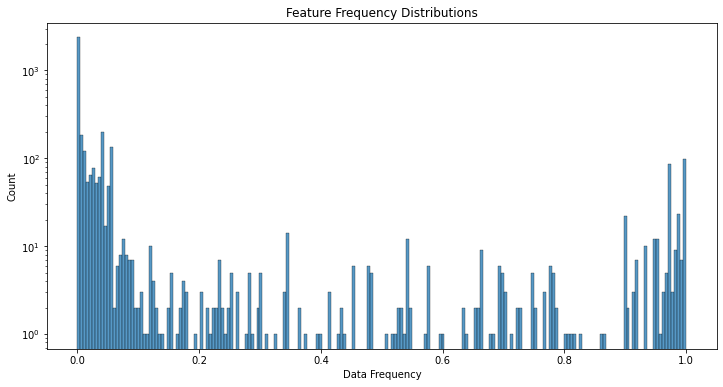

In [30]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.histplot(biobank_index["frequency"], ax=ax)
ax.set_yscale("log")
add_plt_labels(ax, "Data Frequency", "Count", "Feature Frequency Distributions")
plt.show()
fig.tight_layout()
fig.savefig("cover_plots/feature_frequency_distribution.png")

# actual EDA

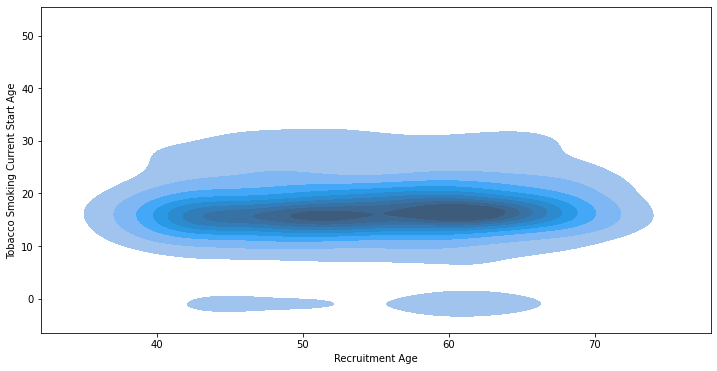

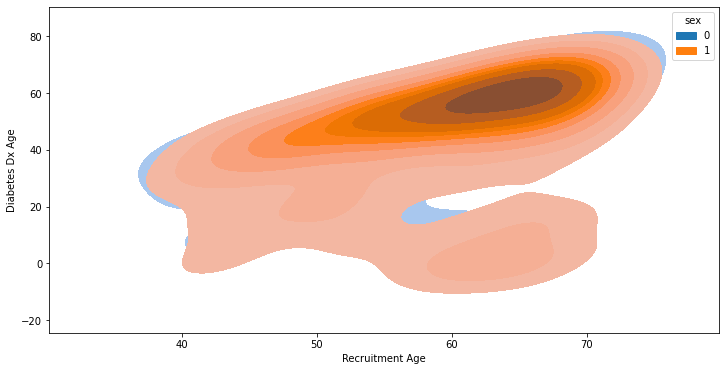

In [35]:
fig, ax = plt.subplots(figsize=(12, 6))
y = "tobacco_smoking_current_start_age"
x = "recruitment_age"

sns.kdeplot(data=biobank_data, y=y, x=x, ax=ax, fill=True)
add_plt_labels(ax, x, y)

y, x = "diabetes_dx_age", "recruitment_age"
fig, ax = plt.subplots(figsize=(12, 6))
sns.kdeplot(data=biobank_data, x=x, y=y, hue="sex", ax=ax, fill=True)
add_plt_labels(ax, x, y)

<AxesSubplot:xlabel='tobacco_smoking_current_start_age', ylabel='Count'>

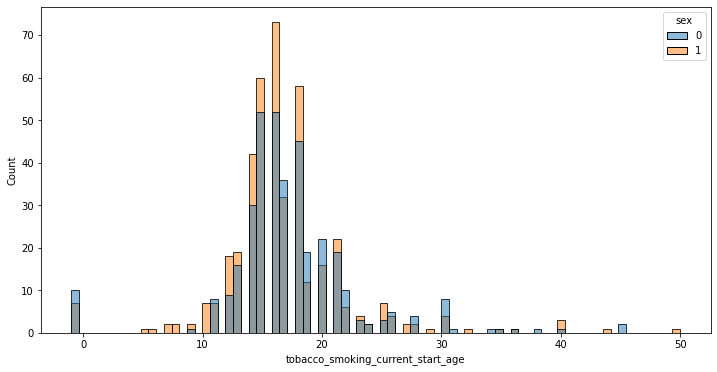

In [36]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.histplot(data=biobank_data, x="tobacco_smoking_current_start_age", hue="sex",  ax=ax)

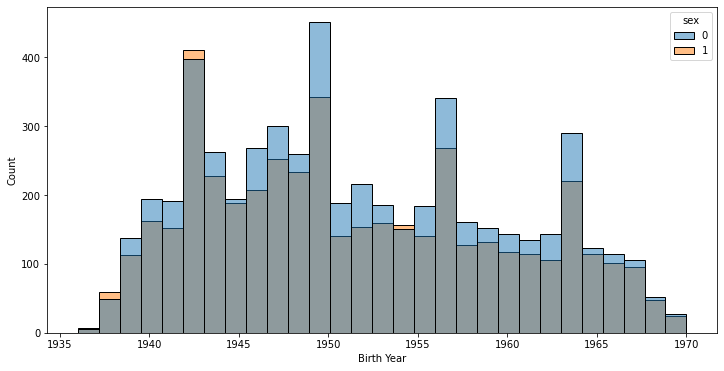

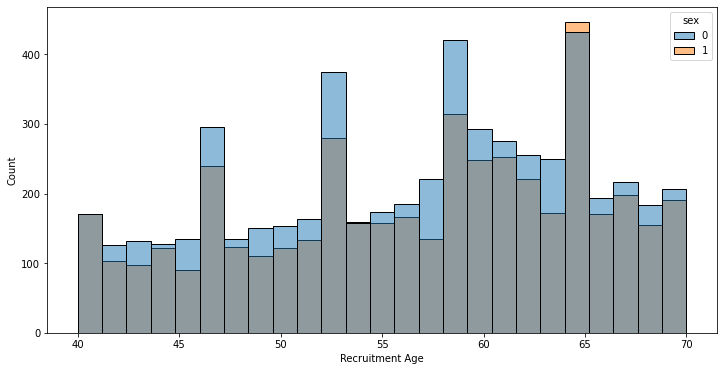

In [37]:
x, hue = "birth_year", "sex"
fig, ax = plt.subplots(figsize=(12, 6))
sns.histplot(data=biobank_data, x=x, hue=hue, ax=ax)
add_plt_labels(ax, x, y="Count")

x = "recruitment_age"
fig, ax = plt.subplots(figsize=(12, 6))
sns.histplot(data=biobank_data, x=x, hue=hue, ax=ax)
add_plt_labels(ax, x, y="Count")